# Sentiment Analysis on Reddit News Headlines with Python’s Natural Language Toolkit (NLTK)

In [1]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import regex as re
import xlsxwriter
from itertools import islice
sns.set(style='darkgrid', context='talk', palette='Dark2')

In [23]:
# Setup Reddit API:
client_id = "" #TODO: enter your custom Reddit API user
client_secret = "" #TODO: enter your custom Reddit API user
username = "" #TODO: enter your custom Reddit API user

subreddit_name = "GTAIV" # Subreddit (example: "GTAV")
bad_keywords = "meme", "gta v", "gta 6", "gta 5", "gta vi", "leak", "video", "cheats", "mod", "mods", "sound" # blacklisted words to filter topics containing these
main_topic = ["graphics", "vfx", "sfx", "video settings", "video quality", "realistic graphics", "fps", "performance"] # keywords to search
max_topics = 100 # in result dataframe

In [5]:
import praw

reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=username)

In [9]:
headlines = set()
topicIDs = []

filtered_topics = 0
parsed_topics = 0

def parse_topics():
    acc = 0
    for topic in main_topic:
        query = reddit.subreddit(subreddit_name).search(topic)
        for submission in query:
            bad_title = any(x in submission.title.lower() for x in bad_keywords)
            skip_submission = len(submission.title) > 255 or bad_title # skip posts with too long submissions
            if skip_submission:
                continue
            topicIDs.append(submission)
            acc = acc + 1
            # if acc == max_comments_pers_post:
            #     break
    return acc
        
parsed_topics = parse_topics()
    
print("Parsed: "+str(len(topicIDs))+" posts")

Parsed: 242 posts


In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = {}
for topic in topicIDs:
    
    #print("parsed: "+str(topic)+"; Title: "+topic.title)
    results[topic.title] = []
    for comment in topic.comments.list():
        if not hasattr(comment, 'body'):
            continue
        pol_score = sia.polarity_scores(comment.body)
        pol_score['headline'] = comment.body
        pol_score['topic'] = topic.title
        results[topic.title].append(pol_score)
        
# trim dictionary
size_of_directory = max_topics * len(main_topic)

results = {k: results[k] for k in list(results.keys())[:size_of_directory]}
for topic in results:
    semantics = results[topic]
    
print("All comments were collected!")

In [11]:
dataframes = {}
backup = {}
for topic in results:
    dataframes[topic] = pd.DataFrame.from_records(results[topic])
    backup[topic] = pd.DataFrame.from_records(results[topic])

In [12]:
compound_limit = 0.35
for topic in results:
    if "compound" not in dataframes[topic]:
        continue
    dataframes[topic]['label'] = 0
    dataframes[topic].loc[dataframes[topic]["compound"] > compound_limit, 'label'] = 1
    dataframes[topic].loc[dataframes[topic]["compound"] < -compound_limit, 'label'] = -1
    dataframes[topic] = dataframes[topic].drop(['pos', 'neg', 'neu', 'compound'], axis=1)
    dataframes[topic]['avg'] = (dataframes[topic].label.value_counts(normalize=True) * 100)
    #print("Successfully processed topic: " + topic)

Subreddit: 'GTAIV'
Search query keywords: '['graphics', 'vfx', 'sfx', 'video settings', 'video quality', 'realistic graphics', 'fps', 'performance']'
Search query blackwords: '('meme', 'gta v', 'gta 6', 'gta 5', 'gta vi', 'leak', 'video', 'cheats', 'mod', 'mods', 'sound')'
Compound limit: 0.35
Parsed topics: 242
Amount of topics after blackwords filtering: 207
neu: 758
neg: 207
pos: 612

Positive/negative ratio:
neg_perc: 0.25274725274725274
pos_perc: 0.7472527472527473

-1    0.252747
 1    0.747253
dtype: float64


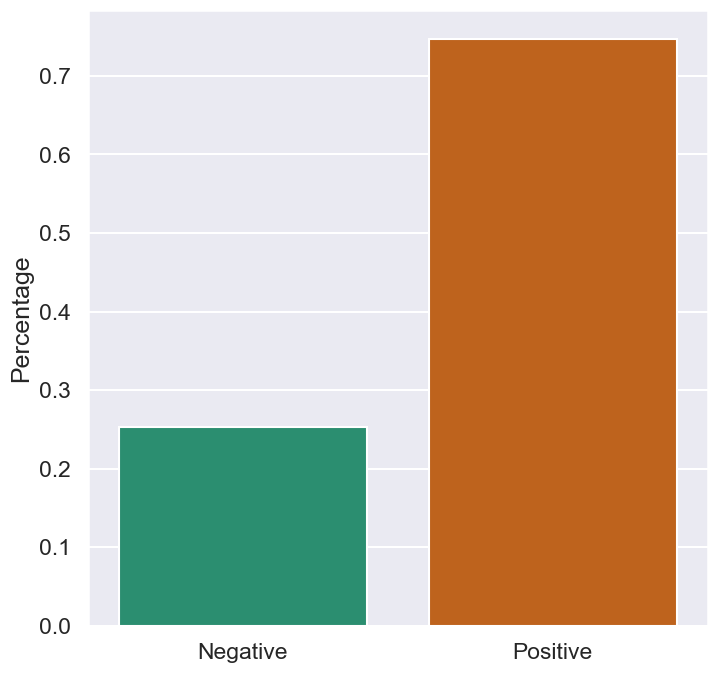

In [18]:
neu = 0
neg = 0
pos = 0
for topic in results:
    
    if dataframes[topic].empty:
        continue
    if 0 in dataframes[topic].label.value_counts():
        neu = neu + dataframes[topic].label.value_counts()[0]
        
    if -1 in dataframes[topic].label.value_counts():
        neg = neg + dataframes[topic].label.value_counts()[-1]
        
    if 1 in dataframes[topic].label.value_counts():
        pos = pos + dataframes[topic].label.value_counts()[1]
    
print("Subreddit: '"+subreddit_name+"'")
print("Search query keywords: '"+str(main_topic)+"'")
print("Search query blackwords: '"+str(bad_keywords)+"'")
print("Compound limit: "+str(compound_limit))
print("Parsed topics: "+str(parsed_topics))
print("Amount of topics after blackwords filtering: "+str(len(results)))
summa = pos + neg
ser = pd.Series(data={1: pos/summa, -1: neg/summa}, index=[-1, 1])
print("neu: " + str(neu))
print("neg: " + str(neg))
print("pos: " + str(pos)+"\n")
print("Positive/negative ratio:")
print("neg_perc: " + str(neg/summa))
print("pos_perc: " + str(pos/summa))
print()
print(ser)
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(x=ser.index, y=ser, ax=ax)

ax.set_xticklabels(['Negative', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [19]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

def process_text(headlines):
    tokens = []
    for s in headlines:
        for line in s:
            # print(line)
            line = str(line.lower())
            toks = tokenizer.tokenize(line)
            toks = [t for t in toks if t not in stop_words]
            tokens.extend(toks)
    
    return tokens

In [20]:
print(len(dataframes))

207


In [21]:
pos_lines = []

for topic in results:
    if dataframes[topic].empty:
        continue
    pos_lines.append(dataframes[topic][dataframes[topic].label == 1]["headline"])

pos_tokens = process_text(pos_lines)

# in case we need to filter out some nonsense words
blacklist = "0", "better", "4", "1", "really", "much", "com", "even", "well", "still", "thanks", "also", "https","iv", "would", "best", "get", "one", "gta", "like", "game", "v"

def conds(x):
    if x in blacklist:
        return 0
    return 1
new_list = list(filter(lambda x: conds(x), pos_tokens))

pos_freq = nltk.FreqDist(new_list)
pos_freq.most_common(20)

[('fps', 98),
 ('pc', 88),
 ('play', 84),
 ('good', 79),
 ('performance', 65),
 ('time', 60),
 ('people', 59),
 ('games', 56),
 ('think', 54),
 ('try', 54),
 ('graphics', 53),
 ('know', 53),
 ('dxvk', 51),
 ('see', 50),
 ('use', 50),
 ('way', 49),
 ('version', 49),
 ('settings', 46),
 ('mods', 45),
 ('run', 44)]

In [22]:
neg_lines = []
for topic in results:
    if dataframes[topic].empty:
        continue
    neg_lines.append(dataframes[topic][dataframes[topic].label == -1].headline)

neg_tokens = process_text(neg_lines)

# in case we need to filter out some nonsense words
blacklist = "0", "better", "4", "1", "really", "much", "com", "even", "well", "still", "thanks", "also", "https","iv", "would", "best", "get", "one", "gta", "like", "game", "v", "2", "run", "know", "use"

def conds(x):
    if x in blacklist:
        return 0
    return 1
new_list = list(filter(lambda x: conds(x), neg_tokens))

neg_freq = nltk.FreqDist(new_list)
neg_freq.most_common(20)

[('fps', 35),
 ('problem', 30),
 ('pc', 21),
 ('try', 21),
 ('bad', 19),
 ('time', 17),
 ('fix', 17),
 ('settings', 17),
 ('good', 16),
 ('got', 16),
 ('missions', 15),
 ('version', 15),
 ('fuck', 15),
 ('way', 15),
 ('steam', 15),
 ('high', 15),
 ('sure', 14),
 ('shit', 14),
 ('old', 14),
 ('make', 13)]